## 라이브러리 및 패키지 설치, 임포트

In [32]:
!pip install hangul_utils
!pip install jamo

import numpy as np
import pickle
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from jamo import h2j, j2hcj
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Embedding, LSTM, Masking, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split


  Using cached hangul_utils-0.4.5-py3-none-any.whl (20 kB)
INFO: pip is looking at multiple versions of hangul-utils to determine which version is compatible with other requirements. This could take a while.
  Using cached hangul_utils-0.4.4-py3-none-any.whl (20 kB)
  Using cached hangul_utils-0.4.3-py3-none-any.whl (20 kB)
  Using cached hangul_utils-0.4.2-py3-none-any.whl (20 kB)
  Using cached hangul_utils-0.4.1-py3-none-any.whl (20 kB)
  Using cached hangul_utils-0.4-py3-none-any.whl (20 kB)
  Using cached hangul-utils-0.3.0.tar.gz (4.3 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, no

## 데이터 로딩 및 전처리

In [33]:
### 데이터 로딩 ###


pickle_file_path = "/content/eng_database.pkl"
with open(pickle_file_path,'rb') as f:
    data = pickle.load(f)

for idx, val in enumerate(data):
    data[idx]['origin_lang'] = re.sub('[^a-zA-Z]', '', val['origin_lang'])


In [34]:
### 데이터 전처리 ###


src = []
trg = []
for idx, val in enumerate(data):
    src.append([val['origin_lang']])
    # 단어의 초성, 중성, 종성 분해
    trg.append([_ for _ in j2hcj(h2j(val['pronun_list']))])

print(f"Test result")
for idx, val in enumerate(src[:10]):
  print(f"{idx} src: {val}, trg: {trg[idx]}")


Test result
0 src: ['gargoyles'], trg: ['ㄱ', 'ㅏ', 'ㄱ', 'ㅗ', 'ㅇ', 'ㅣ', 'ㄹ', 'ㅅ', 'ㅡ']
1 src: ['gargle'], trg: ['ㄱ', 'ㅏ', 'ㄱ', 'ㅡ', 'ㄹ']
2 src: ['gahnite'], trg: ['ㄱ', 'ㅏ', 'ㄴ', 'ㅏ', 'ㅇ', 'ㅣ', 'ㅌ', 'ㅡ']
3 src: ['ganaxolone'], trg: ['ㄱ', 'ㅏ', 'ㄴ', 'ㅏ', 'ㄱ', 'ㅅ', 'ㅗ', 'ㄹ', 'ㄹ', 'ㅗ', 'ㄴ']
4 src: ['garnetting'], trg: ['ㄱ', 'ㅏ', 'ㄴ', 'ㅔ', 'ㅌ', 'ㅣ', 'ㅇ']
5 src: ['garnett'], trg: ['ㄱ', 'ㅏ', 'ㄴ', 'ㅔ', 'ㅅ']
6 src: ['ganoin'], trg: ['ㄱ', 'ㅏ', 'ㄴ', 'ㅗ', 'ㅇ', 'ㅣ', 'ㄴ']
7 src: ['garni'], trg: ['ㄱ', 'ㅏ', 'ㄴ', 'ㅣ']
8 src: ['garnish'], trg: ['ㄱ', 'ㅏ', 'ㄴ', 'ㅣ', 'ㅅ', 'ㅣ']
9 src: ['garnierite'], trg: ['ㄱ', 'ㅏ', 'ㄴ', 'ㅣ', 'ㅇ', 'ㅓ', 'ㄹ', 'ㅏ', 'ㅇ', 'ㅣ', 'ㅌ', 'ㅡ']


In [35]:
### 문자-인덱스 매핑 생성 ###


# English Data
space = [' ']
pad = ['<pad>']
big = [chr(i) for i in range(ord('A'), ord('Z')+1)]
small = [chr(i) for i in range(ord('a'), ord('z')+1)]
english_letter_list = pad + big + small + space
idx2english = dict(enumerate(english_letter_list, 0))
english2idx = {v:k  for k,v in idx2english.items()}

# Korean Data
consonants = [chr(letter) for letter in range(ord('ㄱ'), ord('ㅎ')+1)]
vowel = [chr(letter) for letter in range(ord('ㅏ'), ord('ㅣ')+1)]
korean_letter_list = pad + consonants + vowel + space
idx2korean = dict(enumerate(korean_letter_list, 0))
korean2idx = {v: k for k, v in idx2korean.items()}

print(f"Test result")
print(f"english_letter_list_length: {len(english_letter_list)}")
print(f"korean_letter_list_length: {len(korean_letter_list)}")


Test result
english_letter_list_length: 54
korean_letter_list_length: 53


In [36]:
### 인코딩 및 패딩 처리 ###


# 영어, 한글 문자를 해당 인덱스 값으로 변환
src2idx = [[english2idx[char] for word in wordlist for char in word] for wordlist in src]
trg2idx = [[korean2idx[char] for word in wordlist for char in word] for wordlist in trg]

# 각 리스트의 최대 길이 계산
max_len_src = max(len(src2idx_list) for src2idx_list in src2idx)
max_len_trg = max(len(trg2idx_list) for trg2idx_list in trg2idx)
max_len = max(max_len_src, max_len_trg)

# 주어진 리스트를 최대 길이로 패딩하여 모든 시퀀스를 동일한 길이로 설정
def padding(st_list, max_length, is_trg):
  for tmp_list in st_list:
    while len(tmp_list) < max_length:
      tmp_list.append(0) # 패딩 값으로 0 추가

padding(src2idx, max_len_src, False)
padding(trg2idx, max_len_trg, True)

## 모델 학습

In [37]:
### 데이터 준비 및 인코딩 ###


# 텐서플로우용 데이터 준비
src2idx_tensorflow = src2idx
trg2idx_tensorflow = trg2idx

# One-hot Encoding
X = src2idx_tensorflow
y = trg2idx_tensorflow
X = np.array(X)
y = np.array(y)
from keras.utils import np_utils
num_classes = len(korean_letter_list)
y = np_utils.to_categorical(y, num_classes=num_classes).reshape(y.shape[0], y.shape[1], num_classes)

print(y.shape)
print(X.shape)

(61238, 50, 53)
(61238, 50)


In [38]:
### 데이터 분할 및 모델 설정 ###


# train & test & validation set 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

# 모델 및 데이터셋 Parameters 설정
HIDDEN_SIZE = 200
BATCH_SIZE = 100
LAYERS = 2
MAX_EPOCHS = 100
EMBEDDING_OUTPUT_SIZE = 200
stop_monitor = 'val_accuracy'
stop_delta = 0.005
stop_epochs = 20


In [39]:
### Seq2Seq 모델 구축 및 학습 ###


print(f"Build Model...")
model = Sequential()

# 임베딩 레이어
model.add(Embedding(input_dim=len(english_letter_list)+1, output_dim=EMBEDDING_OUTPUT_SIZE, input_length=X.shape[1], mask_zero=True))
model.add(BatchNormalization())

# 첫 번째 LSTM 레이어
model.add(LSTM(HIDDEN_SIZE, return_sequences=True, input_shape=(X.shape[1], )))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# 두 번째 LSTM 레이어
model.add(LSTM(HIDDEN_SIZE))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# 출력 길이 조절
model.add(RepeatVector(y.shape[1]))

# 추가 LSTM 레이어들
for _ in range(LAYERS):
    model.add(LSTM(HIDDEN_SIZE, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

# TimeDistributed를 사용하여 각 시간 단계에 대해 Dense 레이어 적용
model.add(TimeDistributed(Dense(len(korean_letter_list))))
model.add(Activation('softmax'))

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
print('Done')

# 조기 종료 설정
callbacks_list = [EarlyStopping(monitor=stop_monitor, min_delta=stop_delta, patience=stop_epochs, verbose=1, mode='auto')]

# 모델 학습
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, verbose=1, callbacks=callbacks_list)

# 모델 저장
model.save('our_sam_model.h5')
print(f"Model saved.")



Build Model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 200)           11000     
                                                                 
 batch_normalization_6 (Batc  (None, 50, 200)          800       
 hNormalization)                                                 
                                                                 
 lstm_5 (LSTM)               (None, 50, 200)           320800    
                                                                 
 dropout_4 (Dropout)         (None, 50, 200)           0         
                                                                 
 batch_normalization_7 (Batc  (None, 50, 200)          800       
 hNormalization)                                                 
                                                                 
 lstm_6 (LSTM)               (None, 200

575/575 [==============================] - 6s 10ms/step - loss: 0.2102 - accuracy: 0.9471

Last Model: 
Loss: 0.21
Accuracy: 0.95


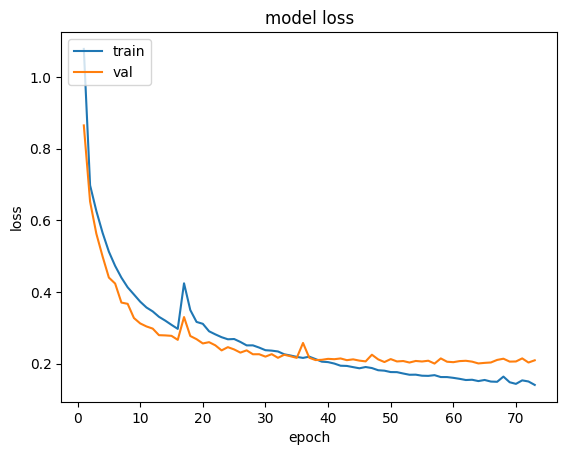

In [40]:
### 모델 평가 및 시각화 ###


loss, acc = model.evaluate(X_test, y_test)
print()
print(f"Last Model: ")
print(f"Loss: %.2f" % loss)
print(f"Accuracy: %.2f" % acc)

epochs = range(1, len(hist.history['accuracy']) + 1)
plt.plot(epochs, hist.history['loss'])
plt.plot(epochs, hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 학습된 모델 테스트

In [41]:
### 전처리 함수 정의 ###


# model = load_model('/content/our_sam_model.h5')

# 영어 문자열을 인덱스 변환
def eng2idx(str1):
    str2idx = [char for char in str1]
    str2idx1 = [english2idx[char] for char in str2idx]
    while len(str2idx1) < max_len_src:
        str2idx1.append(0)
    return [str2idx1]

# 모델로 입력 문자열에 대한 한글 발음 예측
def one_hot2idx(model, str):
    predic = model.predict(eng2idx(str))
    predic_char = predic[0][0]
    _idx2korean = []
    for idx, val in enumerate(predic[0]):
        max_index = np.argmax(val)
        _idx2korean.append(max_index)
    idx2korean_ = [idx2korean[idx] for idx in _idx2korean if idx != 0]
    return idx2korean_

# 자음, 모음으로 이루어진 한글 합치기
def combine_korean_characters(characters):
    # 초성, 중성, 종성 리스트
    cho = ['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']
    jung = ['ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅚ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']
    jong = ['', 'ㄱ', 'ㄲ', 'ㄳ', 'ㄴ', 'ㄵ', 'ㄶ', 'ㄷ', 'ㄹ', 'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅁ', 'ㅂ', 'ㅄ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']

    # 모음과 모음 사이에 하나의 자음만 있는 경우 처리
    idx = 0
    while idx < len(characters) - 2:
        if characters[idx] in jung and characters[idx+1] in cho and characters[idx+2] in jung:
            characters.insert(idx+1, '')
            idx += 2
        else:
            idx += 1

    result = []
    idx = 0
    while idx < len(characters):
        c = characters[idx]
        # c가 초성인 경우
        if c in cho:
            # 현재 문자와 다음 두 문자를 조합하여 한글 문자 생성
            try:
                a = cho.index(c)
                b = jung.index(characters[idx+1])
                c = jong.index(characters[idx+2])
                combined_char = chr(a * 21 * 28 + b * 28 + c + 0xAC00)
                result.append(combined_char)
                idx += 3
            except (IndexError, ValueError):  # 다음 문자가 없거나 종성이 없는 경우
                try:
                    a = cho.index(c)
                    b = jung.index(characters[idx+1])
                    combined_char = chr(a * 21 * 28 + b * 28 + 0xAC00)
                    result.append(combined_char)
                    idx += 2
                except (IndexError, ValueError):  # 다음 문자가 없는 경우
                    result.append(c)
                    idx += 1
        else:
            result.append(c)
            idx += 1

    return ''.join(result)

In [45]:
### 테스트 및 출력 ###

words_to_test = ["haribo", "dermatix", "pringles", "lotte", "samsung", "hyundai", "busan", "control", "maxforce", "monalisa", "gimchi", "Jangjeondong"]

for word in words_to_test:
    result = one_hot2idx(model, word)
    print(f"Input: {word}, Output: {combine_korean_characters(result)}")


1/1 [==============================] - 0s 41ms/step
Input: haribo, Output: 하리보
1/1 [==============================] - 0s 37ms/step
Input: dermatix, Output: 데마틱스
1/1 [==============================] - 0s 37ms/step
Input: pringles, Output: 프링레스
1/1 [==============================] - 0s 41ms/step
Input: lotte, Output: 로테
1/1 [==============================] - 0s 41ms/step
Input: samsung, Output: 샘성
1/1 [==============================] - 0s 42ms/step
Input: hyundai, Output: 힌데이
1/1 [==============================] - 0s 40ms/step
Input: busan, Output: 부산
1/1 [==============================] - 0s 42ms/step
Input: control, Output: 컨트롤
1/1 [==============================] - 0s 64ms/step
Input: maxforce, Output: 맥스포스
1/1 [==============================] - 0s 60ms/step
Input: monalisa, Output: 모날리자
1/1 [==============================] - 0s 57ms/step
Input: gimchi, Output: 김치
1/1 [==============================] - 0s 59ms/step
Input: Jangjeondong, Output: 쟁즈논동
